# 量子コンピューターで農地収穫量問題を解こう
Kawasaki Quantum Summer Camp 2025

Yuri Kobayashi, IBM Quantum (July 31, 2025)


## はじめに <a id='Introduction'></a>

量子コンピューターは、古典コンピューターでは解けない問題を解決する可能性を秘めています。

実社会で有用な計算において量子コンピューターが古典コンピューターの計算速度を上回り、その優位性を示す領域を特定することは、量子コンピューターが実用化される時代に向けてとても重要なことです。このような優位性が期待される領域には、機械学習、計算化学、組み合わせ最適化問題などが挙げられます。今回はアフリカの食料問題をテーマに、農地の収穫量を最大化することを目的とした組み合わせ最適化問題を取り上げます。

### 準備：必要なモジュールとライブラリのインポート
最初に必要なモジュールとライブラリをインポートしておきましょう。Jupyter notebookでは、セルにカーソルを置き、Shift+Enterを押すと、セル内のコードが実行されます。

それでは、まずはインストールされているQiskitのバージョンを調べてみましょう。バージョンを確認するには、qiskitライブラリをインポートしてから、以下のようなコマンドを実行します。

In [ ]:
# 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from qiskit import QuantumCircuit

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import Batch, SamplerOptions, Session
from qiskit.primitives import StatevectorEstimator
from qiskit_aer.primitives import SamplerV2
from qiskit_aer import AerSimulator

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz

以上で準備は完了です。

## 農地の収穫量問題 <a id="CropYieldProblem"></a>
農場の作物や経営を最適化して、リスクを減らしながら利益を上げたいというニーズはよくあります。アフリカや全世界が直面している大きな課題の1つは、すべての人に十分な食料をいかに生産するかということです。今回問題とするのは、利益ではなく、収穫した作物のトン数です。農地の広さが決められ、植えられる作物の種類が与えられたとき、どの作物をそれぞれ何ヘクタール植えたら、収穫量を最大にできるかが課題になります。

<table>
    <tr>
        <th>
            <img src="farm_template.svg" width="384px"/>
        </th>
    </tr>
    <tr>
        <th>
            あなたの経営する美しい3ha(ヘクタール)の農場
        </th>
    </tr>
</table>

<table>
    <tr>
        <th>
        <img src="crop_wheat.svg" width="256px"/>
        </th>
        <th>
            <img src="crop_soybeans.svg" width="256px"/>
        </th>
        <th>
            <img src="crop_maize.svg" width="256px"/>
        </th>
        <th>
            <img src="crop_pushpull.svg" width="256px"/>
        </th>
    </tr>
    <tr>
        <th>
            小麦
        </th>
        <th>
            大豆
        </th>
        <th>
            トウモロコシ
        </th>
        <th>
            プッシュプル
        </th>
<!--         <th>
            <p align="right" style="height:32px;padding-top:10px;">Wheat<img src="wheat.svg" width="32px" style="float:left;margin-top:-10px;margin-right:8px;"/></p>
        </th>
        <th>
            <p style="height:32px;padding-top:10px;">Soybeans<img src="soybeans.svg" width="32px" style="float:left;margin-top:-10px;margin-right:8px;"/></p>
        </th>
        <th>
            <p style="height:32px;padding-top:10px;">Maize<img src="maize.svg" width="32px" style="float:left;margin-top:-10px;margin-right:8px;"/></p>
        </th>
        <th>
            <p style="height:32px;padding-top:10px;">Push-Pull<img src="pushpull.svg" width="32px" style="float:left;margin-top:-10px;margin-right:8px;"/></p>
        </th> -->
    </tr>
</table>

農法には「単作」「間作」「プッシュプル農法」の3種類があります。単作とは、一つの作物だけを栽培する方法です。単作では、病気や害虫の影響を受けやすく、収穫量全体に影響を及ぼします。また、異なる作物を近くで栽培すると、両方の収穫量が増えたり、逆に収穫量が減ったりします。間作とは、収穫量を増やすために2つの異なる作物を選択することです。プッシュプル農法とは、害虫を寄せ付けないプッシュ作物と、害虫を引き寄せるプル作物をペアで栽培することです。これを大規模な農場に組み込むことで、収穫量を増やすことができます。ただ、プッシュプル作物は利用できなかったり食用にならないため、プッシュプル作物を全体の収穫量として使用できません。
<table>
    <tr>
        <th>
        <img src="farm_mono.svg" width="256px"/>
        </th>
        <th>
            <img src="farm_intercrop.svg" width="256px"/>
        </th>
        <th>
            <img src="farm_intercrop_pushpull.svg" width="256px"/>
        </th>
    </tr>
    <tr>
        <th>
            単作
        </th>
        <th>
            間作
        </th>
        <th>
            プッシュプル農法
        </th>
    </tr>
</table>

このような農地の収穫量問題は、変数の特定の組み合わせで解が得られるという点で、組合せ最適化問題です。ここで紹介する問題は古典的に解くことができるほど小さいものですが、より大きな問題になると、最適化すべき組み合わせの数が多くなるため、古典的なコンピュータでは扱いにくくなります。

### 目的：収穫量の最大化
あなたは$3~ha$の農場のオーナーです。植えられる作物は、小麦、大豆、トウモロコシ、プッシュプルの4種類です。プッシュプルは、収穫しても売ることはできませんが、他の作物の収穫量を増やすことができます。それぞれの作物は$0~ha$または$1~ha$作付けすることができます。この農場の収穫量(トン)を以下のような2次関数として定義します。この2次関数の変数は、作付けする作物の作付け面積（ヘクタール数）です。解きたい問題は、どの作物の組合せを選べば、最大の収穫量が得られるか(2次関数を最大化できるか)ということです。

#### 作物の種類
<img src="qubo_problem_graphical_variables.svg" width="534px"/> <br>
$~$$~$$~$$~$$~$$~$$~$$~$$~$$~$$~$$~$$~$$~$$~$$~$小麦　　　　　　　大豆　　　　　　トウモロコシ　　　　　プッシュプル

#### 問題の定式化
<img src="qubo_problem_graphical.svg" width="400px"/>


$$
\begin{align}
    \text{maximize} \quad & 2(\operatorname{Wheat}) + \operatorname{Soybeans} + 4(\operatorname{Maize}) \\
    & + 2.4(\operatorname{Wheat}\times\operatorname{Soybeans}) \\ & + 4(\operatorname{Wheat}\times\operatorname{Maize})\\
    &+ 4(\operatorname{Wheat}\times\operatorname{PushPull}) \\ & + 2(\operatorname{Soybeans}\times\operatorname{Maize}) \\
                          & + (\operatorname{Soybeans}\times\operatorname{PushPull}) \\ & + 5(\operatorname{Maize}\times\operatorname{PushPull})
\end{align}
$$

$$
\begin{align}
\text{subject to} \quad & \operatorname{Wheat} + \operatorname{Soybeans} + \operatorname{Maize} + \operatorname{PushPull} \leq{} 3\\
& 0\leq{}\operatorname{Wheat}\leq{}1\\
& 0\leq{}\operatorname{Soybeans}\leq{}1\\
& 0\leq{}\operatorname{Maize}\leq{}1\\
& 0\leq{}\operatorname{PushPull}\leq{}1
\end{align}
$$

### 演習：量子コンピューターが計算できる形２次計画問題を作成してみましょう

上記で定義した問題を表す２次計画問題（`QuadraticProgram`）を作成するための準備として、 `cropyield_quadratic_program` 関数を定義します。つづいて、上記の目的関数にある各変数の係数をみながら、以下の「**#目的関数の定義**」と「**#制約の追加**」の各コメント下の式にそれぞれ係数を代入してみましょう。

変数名は何でもよいですが、ここでは `W`、 `S`、 `M`、 および `P`を使っています。

In [ ]:
#穴埋め問題
# 先に、２次計画問題 (Quadratic Program)の作成準備をしておきます。

from qiskit_optimization import QuadraticProgram

def cropyield_quadratic_program():
    cy = QuadraticProgram(name="Crop Yield")

    # Binary decision variables
    cy.binary_var(name="W")  # Wheat (麦)
    cy.binary_var(name="S")  # Soybeans (大豆)
    cy.binary_var(name="M")  # Maize (トウモロコシ)
    cy.binary_var(name="P")  # Pushpull (プッシュプル)

    # 問題の定式化(穴埋め問題)
    ##############################
    
    # 定式化のパートはここから。単作と間作の係数をそれぞれ当てはめてください。
    # 目的関数の定義
    cy.maximize(
        linear={"W": , "S": , "M": },
        quadratic={
            ("W", "S"): ,
            ("W", "M"): ,
            ("W", "P"): ,
            ("S", "M"): ,
            ("S", "P"): ,
            ("M", "P"): 
        }
    )

    # 制約: 選べる作物の品種 ≤ 3
    # 以下に各作物をいくつまで選択できるか、そして選べる品種は３種類以下であるという制約条件を設定してください。
    cy.linear_constraint(linear={"W": , "S": , "M": , "P": }, sense="<=", rhs=)
    
    ##############################
    
    return cy

In [ ]:
cy = cropyield_quadratic_program()
# print(cy.export_as_lp_string())
print(cy.prettyprint())

## 古典的な解法 <a id="ClassicalSolution"></a>

この問題はさほど大きくないので、古典的に厳密解を求めることも可能です。実際に量子コンピューターで解く前に、古典的に解を求めておきましょう。これは本日皆さんは実行しなくて大丈夫です。

今回のような２次計画問題は長年研究されてきている最適化問題であり、その最適解を算出するための「ソルバー」と呼ばれるツールがいくつも用意されています。ここではこの農地収穫量問題をIBM ILOC CPLEXと呼ばれるよく知られているソルバーで予め解いた結果だけご紹介します。IBM ILOG CPLEXは通常は有料のライセンスが必要ですが、IBM SkillsBuildのサイトから登録することで[教育目的で利用できる無償ダウンロード版](https://github.com/academic-initiative/documentation/blob/main/academic-initiative/how-to/How-to-download-IBM-ILOG-CPLEX/readme.md)を入手することも可能ですので、興味のある方は学校の先生にお願いをしてアカデミックライセンスを活用してください（注：当ライセンスを得るにはアカデミックドメインのメールアドレス登録が必要です）

In [ ]:
import cplex
from qiskit_optimization.problems.constraint import ConstraintSense

def solve_crop_yield_with_cplex():
    # Get the Qiskit problem
    qp: QuadraticProgram = cropyield_quadratic_program()

    # Extract variable names
    var_names = [var.name for var in qp.variables]
    num_vars = len(var_names)

    # Create a CPLEX model
    model = cplex.Cplex()
    model.set_problem_type(cplex.Cplex.problem_type.MIQP)
    model.objective.set_sense(model.objective.sense.maximize)

    # Silence all output
    model.set_log_stream(None)
    model.set_error_stream(None)
    model.set_warning_stream(None)
    model.set_results_stream(None)

    # Add binary variables
    model.variables.add(names=var_names, types='B' * num_vars)

    # Set linear coefficients
    linear = qp.objective.linear.to_dict()
    model.objective.set_linear(list(linear.items()))

    # Set quadratic coefficients
    for (i, j), coeff in qp.objective.quadratic.to_dict().items():
        model.objective.set_quadratic_coefficients(i, j, coeff)

    
    sense_map = {
    ConstraintSense.LE: "L",
    ConstraintSense.EQ: "E",
    ConstraintSense.GE: "G",
}
    # Add linear constraints
    for constraint in qp.linear_constraints:
        lin_expr = [[], []]
        for var, coeff in constraint.linear.to_dict().items():
            lin_expr[0].append(var)
            lin_expr[1].append(coeff)
        sense_str = sense_map.get(constraint.sense)
        if sense_str is None:
            raise ValueError(f"Unknown constraint sense: {constraint.sense}")
        model.linear_constraints.add(
            lin_expr=[lin_expr],
            senses=[sense_str],
            rhs=[constraint.rhs]
        )

    # Solve
    model.solve()

    # Display results
    if model.solution.is_primal_feasible():
        print("Status:", model.solution.get_status_string())
        print("Objective value:", model.solution.get_objective_value())
        solution = model.solution.get_values()
        for name, val in zip(var_names, solution):
            print(f"{name} = {val}")
    else:
        print("No feasible solution found.")

# Call the function
solve_crop_yield_with_cplex()

古典の厳密解はどのような結果になったでしょうか？この結果を踏まえて、量子コンピューターで解いた結果とあとで付き合わせてみましょう。

## 量子コンピューターで解くための準備 <br/> QUBO形式への変換 <a id="QUBO"></a>


最適化問題を特定の量子アルゴリズムで解くためには、通常、適性なフォーマットに変換して適用可能な状態にする必要があります。今回のような2次計画問題を量子コンピューター解く際には、Quadratic Unconstrained Binary Optimization (QUBO) 形式という特殊な形式に変換します。

## 演習: 農地収穫量問題のQUBOへの変換
私たちの農地収穫量問題をQUBOに変換しましょう。
最適化問題を量子コンピューターが解けるよう、QUBO形式に変換してくれるクラス[QuadraticProgramToQubo](https://qiskit.org/ecosystem/optimization/stubs/qiskit_optimization.converters.QuadraticProgramToQubo.html)を呼び出し、先ほど作成した２次計画問題の`cy`を引数に変換(convert)します。

In [ ]:
# 農地収穫量問題をQUBO形式に変換する
cyQUBO=QuadraticProgramToQubo().convert(cy)

print(cyQUBO.prettyprint())
# print(cyQUBO.export_as_lp_string())

今回の最適化問題を解くのにつかうQAOAと呼ばれる量子アルゴリズムは、入力として[**イジング模型**](https://ja.wikipedia.org/wiki/%E3%82%A4%E3%82%B8%E3%83%B3%E3%82%B0%E6%A8%A1%E5%9E%8B) と呼ばれる数学モデルを要求します。この数学モデルはQUBOのバイナリ変数[0、1]を電子の上向きのスピンと下向きのスピンを現す[+1, -1]の変数に変換し量子コンピューターで問題が解けるようにしてくれます。

In [ ]:
# QUBOをイジング模型に基づく形式（イジング・ハミルトニアン）に変換
cost_hamiltonian, offset = cyQUBO.to_ising()
print("Cost Function Hamiltonian:", cost_hamiltonian, offset)

### QAOAとは？

まず、QAOA(Quantum Approximate Optimization Algorithm)とは最適化問題を解くためのアルゴリズムです。今回の「限られた作付面積に相性のよい作物とそうでない作物をどう植えたら一番収穫量をみこめるか」みたいな問題を、量子の力でうまく解こうとします。QiskitのCircuitライブラリにはQAOAアルゴリズムの基本的な回路を簡単につくってくれる`QAOAAnsatz`という関数があります。まずはこれを使ってQAOAの回路をつくってみましょう。

In [ ]:
#ハミルトニアンをQAOAアルゴリズムに基づく量子回路に実装する

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
# circuit.measure_all()
circuit.draw("mpl")
# circuit.decompose().draw('mpl')

上記QAOAアルゴリズムの量子回路をみると赤いブロックのなかに「γ(ガンマ)」と「β(ベータ)」という記号が見えます。
ここではQAOAを「山の頂上を目指すためのゲーム」を解くためのアルゴリズムにたとえてこれらの記号の意味を説明します。

- γ（ガンマ）は「ゴールの場所を意識する係数」
→ ゴール（=正解）に近づこうとする力(重み付け）です。
- β（ベータ）は「いろんな道を試してみる係数」
→ ゴールだけじゃなくて、山のあらゆるルートを探索する力（重み付け）です。

量子コンピューターは、はじめは全部の道をしらみつぶしに探している状態になります。
そこから、「この道が良さそう」とか「この方向には行かない方がいい」みたいな情報を、γとβを使って調整していきます。

γを強くすると、ゴールに向かって進もうとします（でも、途中にある丘や谷のせいで間違ったゴールに早くたどり着いちゃうかもしれません）。
βを強くすると、いろんな道を試します（でも、ずっと迷ってなかなかゴールにたどり着けなくなってしまうかもしれません）。
つまり、γとβのパラメーターバランスをうまくとることが大事になります。次の節ではこのγとβの値の調整から入ります。

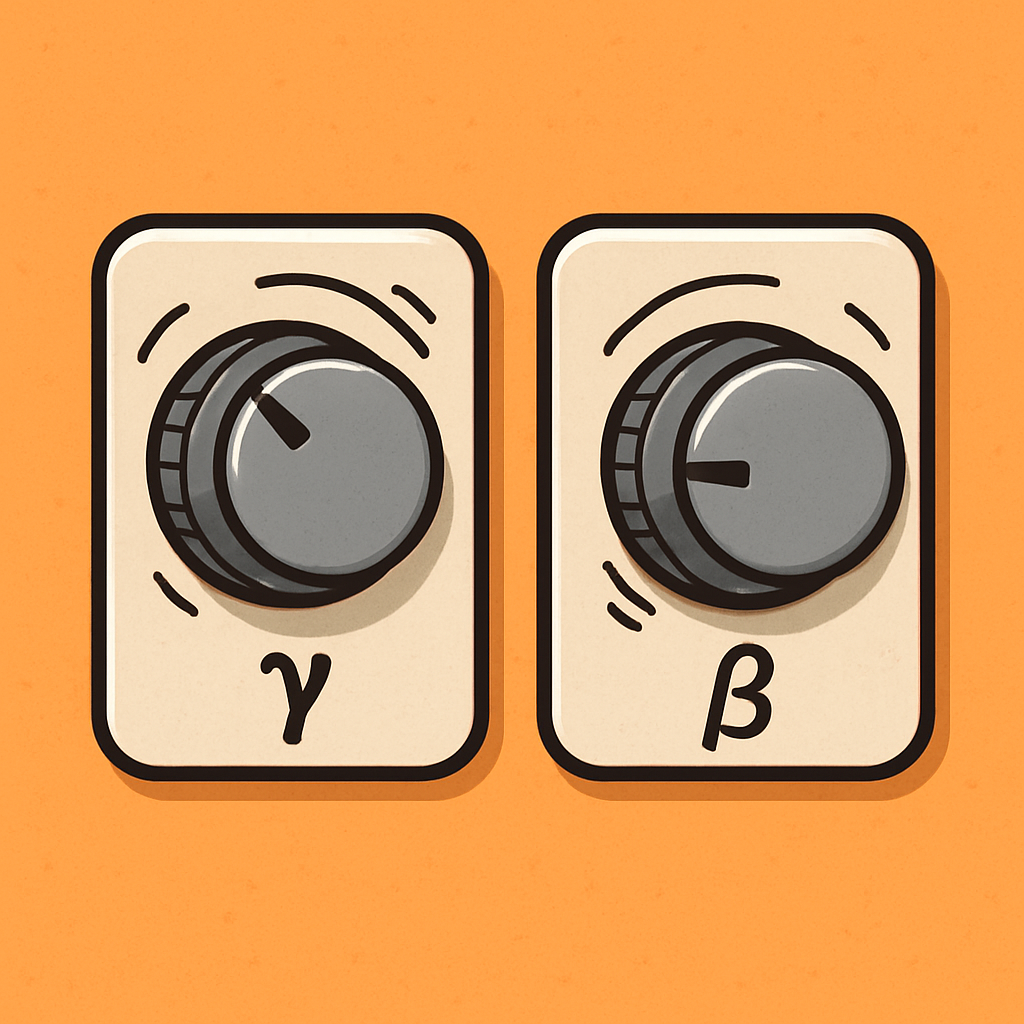

##  量子コンピューター上で回路を実行する準備

### QAOAアルゴリズムのパラメータγとβの最適化

量子コンピューターで回路を実行する前に、γとβを最適な値にチューニングします。まずは任意の値を初期値として設定します。ここではγの初期値をπ/4、βの初期値をπ/8にあわせたところからQAOAの回路を実行し最適なパラメータを探ります。

In [ ]:
# γとβの初期値を設定
initial_gamma = np.pi / 4
initial_beta = np.pi / 8
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

IBMの量子コンピューターとやり取りするには、[Qiskit Runtime のプリミティブ](https://quantum.cloud.ibm.com/docs/en/guides/get-started-with-primitives)を使用します。Qiskit Runtime プリミティブとは、「よくある量子計算の操作を、誰でも簡単・高速に使えるようにしたツール」です。プリミティブには「Sampler」と「Estimator」の２種類があり、どちらを使うかは量子コンピューター上で実行したい測定の種類によって決まります。βとγの最適な値を求めるときはコスト関数の測定が単に期待値の計算になるため、「Estimator」を使用します。

Qiskit Runtimeの主なプリミティブ</b><br>
    
| プリミティブ名 | 概要 | 主な用途 |
|----------------|------|----------|
| **Sampler**    | 量子回路の出力からサンプリングし、擬確率分布を推定 | 探索アルゴリズム（Groverなど）、分類、最適化 |
| **Estimator**  | 量子回路の出力に対する観測量（observable）の期待値を計算 | 量子化学、最適化問題、機械学習のコスト関数評価 |</div>


In [ ]:
# Estimatorの準備
estimator = StatevectorEstimator()

# ショット数と精度の設定
shots = 10_000
precision = np.sqrt(1 / shots)

# 最適化する目的関数の設定：ここではγとβのパラメータ最適化が目的
def cost_fn(params):
    job = estimator.run([(circuit, cost_hamiltonian, params)])
    result = job.result()[0]
    return result.data.evs
    
# 最適化の実行
result = minimize(
    cost_fn,
    init_params,
    method="COBYLA",
    tol=1e-2,
)

print(result)

ここでQAOAの量子回路に「Estimator」がみつけてくれた最適なβとγの値をパラメータとして渡します。パラメータ設定した回路は`optimized_circuit`と呼ぶことにします。

In [ ]:
optimized_circuit = circuit.assign_parameters(result.x)
# optimized_circuit.decompose(reps=2).draw("mpl")
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

上記QAOAの回路をみると「Estimator」がみつけてくれたパラメータが設定されたことが確認されます。(e.g., γ[0.642], β[0.871], γ[0.648], β[0.373])

### Samplerを使って回路を測定し確率分布を
γとβのパラメータ設定が完了したところで、「Sampler」をつかって量子回路の出力からサンプリングし、確率分布を推定します。出力（例えば'010101'のような測定結果得られるビット列のこと）を得るために量子回路に「測定」を追加する必要があります。

In [ ]:
#測定ゲートの追加
optimized_circuit.measure_all()
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

量子回路に測定ゲートが追加されたところで、Aerシミュレーターが提供する「Sampler」をつかって量子回路の出力からサンプリングし、確率分布を推定します。

In [ ]:
from qiskit import transpile
from qiskit_aer import AerSimulator

# バックエンドとしてAerSimulatorを使用
backend = AerSimulator()

# AerSimulatorにあわせた量子回路の最低化
optimized_circuit = transpile(optimized_circuit, backend)

# Samplerの実行
sampler = SamplerV2()
job = sampler.run([optimized_circuit], shots=1_000_000)
result = job.result()
counts = result[0].data.meas.get_counts()

### 測定確率の高いビットストリングから解を導き出す

最も測定確率が高いビットストリングが今回の農地収穫量問題において、量子コンピュータが求めた答えになります。以下のセルを実行して確認してみましょう。

In [ ]:
bit_combinations = {
    0: "W", # 麦
    1: "S", # 大豆
    2: "M", # トウモロコシ
    3: "P", # プッシュプル
}

top = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:1]

# Decode meanings
decoded_labels = []
bitstrings = []
probabilities = []

for bitstring, prob in top:
    meaning = [desc for i, desc in bit_combinations.items() if bitstring[::-1][i] == '1']
    label = f"{bitstring}\n({' + '.join(meaning) if meaning else 'None'})"
    decoded_labels.append(label)
    bitstrings.append(bitstring)
    probabilities.append(prob)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(decoded_labels, probabilities, color='seagreen')
plt.xlabel("Top Bitstring")
plt.ylabel("Counts")
plt.title("Best crop combination for maximizing crop yield")
plt.ylim(0, max(probabilities) * 1.2)
plt.grid(axis='y')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

量子コンピューターで実行した結果はいかがでしょうか？古典解と同じ結果がでたでしょうか？それとも違う結果が出たでしょうか？QAOAアルゴリズムは難しい言葉でいうと[ヒューリスティック](https://ja.wikipedia.org/wiki/%E3%83%92%E3%83%A5%E3%83%BC%E3%83%AA%E3%82%B9%E3%83%86%E3%82%A3%E3%83%83%E3%82%AF)なアルゴリズムで、必ずしも最適な解を保証するわけではありません。そのため、必ずしも厳密解とは同じ答えは出しませんが、完璧な最適解を求めるのではなく、迅速に実用的な解決策を見つけるために有用なアルゴリズムです。

## まとめ <a id="Summary"></a>

いかがでしたか？本日はハンズオンを通して以下を説明しました：

- 最適化問題を解くための流れ
- 定式化からの2次計画問題作成方法（係数の入力）
- 2次計画問題のQUBO形式への変換
- QUBO形式→イジング・ハミルトニアン→量子回路への実装
- 量子アルゴリズムQAOAを適用した解法
- Estimatorをつかったγとβパラメータの調整
- Samplerをつかった最適解の導出

## 参考文献 <a id="Reference"></a>
[1] A. A. Nel, ‘Crop rotation in the summer rainfall area of South Africa’, South African Journal of Plant and Soil, vol. 22, no. 4, pp. 274–278, Jan. 2005, doi: 10.1080/02571862.2005.10634721.

[2] H. Ritchie and M. Roser, ‘Crop yields’, Our World in Data, 2013, [Online]. Available: https://ourworldindata.org/crop-yields.

[3] G. Brion, ‘Controlling Pests with Plants: The power of intercropping’, UVM Food Feed, Jan. 09, 2014. https://learn.uvm.edu/foodsystemsblog/2014/01/09/controlling-pests-with-plants-the-power-of-intercropping/ (accessed Feb. 15, 2021).

[4] N. O. Ogot, J. O. Pittchar, C. A. O. Midega, and Z. R. Khan, ‘Attributes of push-pull technology in enhancing food and nutrition security’, African Journal of Agriculture and Food Security, vol. 6, pp. 229–242, Mar. 2018.

In [ ]:
import qiskit.tools.jupyter

#%qiskit_version_table
%qiskit_copyright